In [34]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from utils.dataset import CocoDataset
from utils.plots import plot_rgb, reconstruct_lab
from utils.models import save_model, load_model

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

TO DO:
- add unet generator
- try out different losses (gan loss, wgan, gan loss with l1 term)
- try to add layers, dropout, remove/add batchnorm, 
- try cgan?

## Data Import

In [36]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [37]:
dataset = CocoDataset(root="coco/images/train2014", transform=transform)

Found 82783 images.


## Data Prep
Consider for now only a small subset of the data (ho copiato baseline.ipynb)

In [38]:
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size

torch.manual_seed(42)
train, test = random_split(dataset, [train_size, test_size], torch.Generator().manual_seed(42))

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size], torch.Generator().manual_seed(42))
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size], torch.Generator().manual_seed(42))
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=True)

## GAN Implementation


In [100]:
class GeneratorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # Input: L channel (1, 64, 64)
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # Output: AB channels (2, 64, 64)
            nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

class GeneratorEncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder--> downsample by a factor of 2
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), # Input: L channel (1, 64, 64)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1), 
        )

        # Decoder --> upsample by a factor of 2
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(512),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid() # Output: AB channels (2, 64, 64)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Input: L channel (1, 64, 64) and AB channels (2, 64, 64)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, ab_channels):
        x = torch.cat([x, ab_channels], dim=1)
        return self.model(x)

In [101]:
NUM_EPOCHS = 100
generator_cnn = GeneratorCNN().to(device)
gen_cnn_opt = optim.Adam(generator_cnn.parameters(), lr=0.0002, betas=(0.5, 0.999))

generator_encdec = GeneratorEncDec().to(device)
gen_encdec_opt = optim.Adam(generator_encdec.parameters(), lr=0.0002, betas=(0.5, 0.999))

discriminator = Discriminator().to(device)
disc_opt = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = torch.nn.BCELoss()

In [102]:
# we don't want to train the discriminator more than the the generator,
# like they do in the original paper. this is because if the discrimintaor
# gets good at recognizing true/colorized images, it will only do that by measuring the pixels.
# instead we deem an image to be colorized well even if the color is not the same as the original.
# for example, if in an image the t-shirt color is blue and the model is able to colorize it properly
# (i.e. uniformly, shadows, etc.) but in red, we (humans) still consider that
# colorized image good, but the discriminator does not, so then the generator learns in a bad way.
# a way to improve this could be having a patch gan discriminator!

def train(generator, gen_opt, d_losses, g_losses):
    for epoch in range(NUM_EPOCHS):
        generator.train()
        discriminator.train()
        loop = tqdm(small_train_loader, leave=True, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
        epoch_d_loss = 0
        epoch_g_loss = 0
        for rgb, l, _, _, ab in loop:
            rgb = rgb.to(device)
            l = l.to(device)
            ab = ab.to(device)

            # Train discriminator
            disc_opt.zero_grad()
            real_ab = ab
            real_output = discriminator(l, real_ab)
            real_loss = criterion(real_output, torch.ones_like(real_output))
            fake_ab = generator(l)
            fake_output = discriminator(l, fake_ab.detach())
            fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            disc_opt.step()
            epoch_d_loss += d_loss.item()

            # Train generator
            gen_opt.zero_grad()
            fake_ab = generator(l)
            fake_output = discriminator(l, fake_ab)
            g_loss = criterion(fake_output, torch.ones_like(fake_output))
            g_loss.backward()
            gen_opt.step()
            epoch_g_loss += g_loss.item()

            loop.set_postfix(d_loss=epoch_d_loss / (loop.n + 1), g_loss=epoch_g_loss / (loop.n + 1))

        d_losses.append(epoch_d_loss / len(small_train_loader))
        g_losses.append(epoch_g_loss / len(small_train_loader))
    
    print("Training complete!")
    return d_losses, g_losses

Epoch 10/10: 100%|██████████| 79/79 [00:37<00:00,  2.10it/s, d_loss=0.424, g_loss=1.91]


Training complete!
Model saved to models\generator_cnn.pth successfully!


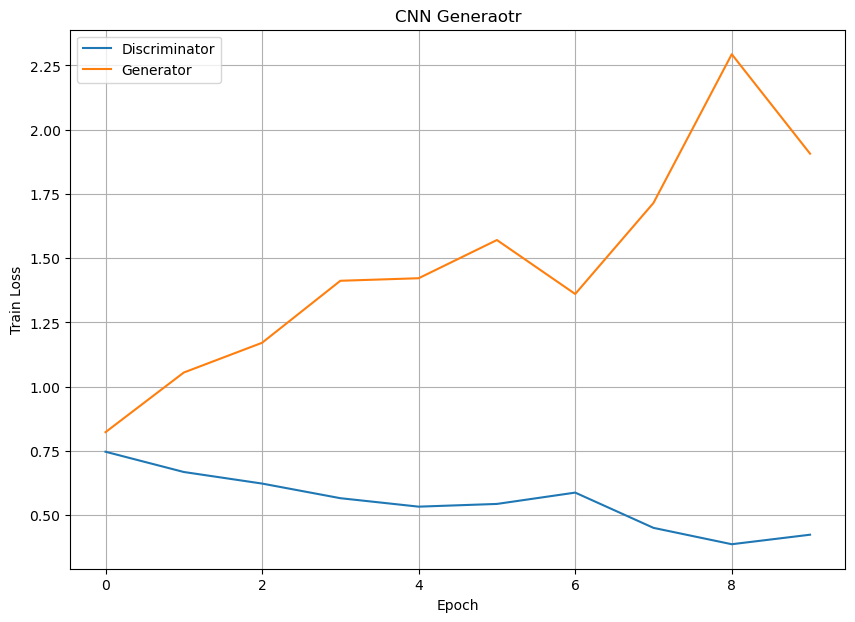

In [103]:
torch.manual_seed(42)
d_losses, g_losses = train(generator_cnn, gen_cnn_opt, [], [])
save_model(generator_cnn, "generator_cnn")

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('CNN Generator')
plt.grid(True)
plt.legend()
plt.show()

In [104]:
torch.manual_seed(42)
d_losses, g_losses = train(generator_encdec, gen_encdec_opt, [], [])
save_model(generator_encdec, "generator_encdec")

Epoch 2/10:  96%|█████████▌| 76/79 [00:27<00:01,  2.72it/s, d_loss=0.566, g_loss=1.69]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Enc-Dec Generator')
plt.grid(True)
plt.legend()
plt.show()

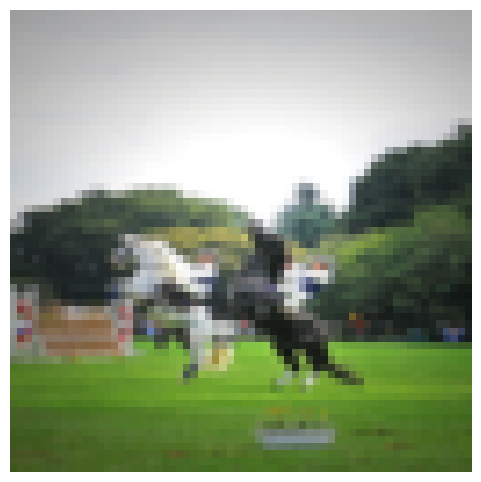

In [112]:
plot_rgb(dataset[5][0])

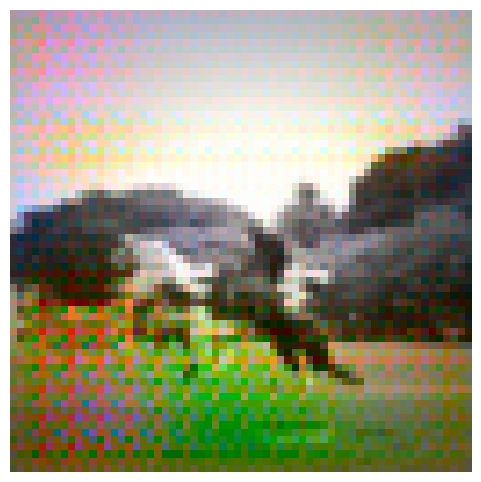

In [113]:
input = dataset[5][1].to(device).unsqueeze(0)
ab = generator_cnn(input).squeeze(0)
reconstruct_lab(dataset[5][1].to(device).detach().cpu(), ab.detach().cpu())

In [ ]:
input = dataset[5][1].to(device).unsqueeze(0)
ab = generator_encdec(input).squeeze(0)
reconstruct_lab(dataset[5][1].to(device).detach().cpu(), ab.detach().cpu())

# Load and Eval

In [114]:
def eval(loaded_model):
    loaded_model.eval()

    total_mse = 0
    total_psnr = 0
    num_samples = 0

    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in small_test_loader:
            l_channels = l_channels.to(device)
            ab_channels = ab_channels.to(device)

            ab_preds = loaded_model(l_channels)

            mse = F.mse_loss(ab_preds, ab_channels)
            total_mse += mse.item() * ab_channels.size(0)

            max_pixel_value = 1  # image values are between 0 and 1
            psnr = 20 * torch.log10(max_pixel_value**2 / mse)
            total_psnr += psnr.item() * ab_channels.size(0)

            num_samples += ab_channels.size(0)

    avg_mse = total_mse / num_samples
    avg_psnr = total_psnr / num_samples

    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f}")
    # note: if you run this cell over and over you get slighly different values in the 
    # decimal places for avg psnr possibly because of numerical errors, since when
    # we divide by mse, that value is very small and then we take the log of that,
    # so there can be "errors" of this type to keep in mind.

In [9]:
cnn_trained = load_model(GeneratorCNN(), "models/generator_cnn.pth").to(device)
img = dataset[5276]
input = img[1].to(device).unsqueeze(0)
print(F.mse_loss(img[-1].to(device), cnn_trained(input).squeeze(0)).item())
plot_rgb(img[0])
reconstruct_lab(img[1].detach().cpu(), cnn_trained(input).squeeze(0).detach().cpu())

Generator model loaded successfully!


In [36]:
eval(cnn_trained)

Average MSE: 0.0050
Average PSNR: 46.0256


In [ ]:
encdec_trained = load_model(GeneratorEncDec(), "models/generator_encdec.pth").to(device)
img = dataset[5276]
input = img[1].to(device).unsqueeze(0)
print(F.mse_loss(img[-1].to(device), encdec_trained(input).squeeze(0)).item())
plot_rgb(img[0])
reconstruct_lab(img[1].detach().cpu(), encdec_trained(input).squeeze(0).detach().cpu())

In [ ]:
eval(encdec_trained)